In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

from spatial_tools.graph import ripleyK

%load_ext autoreload
%autoreload 2
%load_ext lab_black

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"

In [3]:
dataset_name = "V1_Human_Lymph_Node"
dataset_folder = os.path.join(
    BASE_PATH, "20191218_10XVisium_HumanLymphNode_giovanni.palla"
)
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Let's do some basic preprocessing and clustering

In [4]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [5]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [6]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

We can visualize clusters both in UMAP and in spatial context

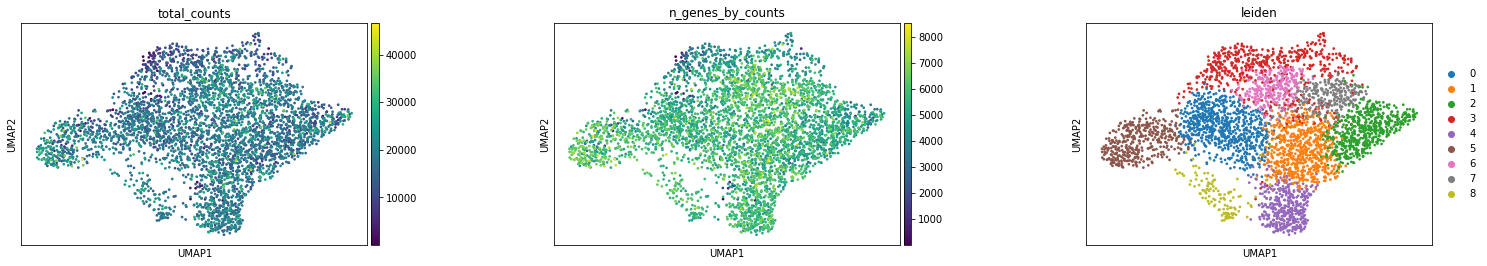

In [8]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4)

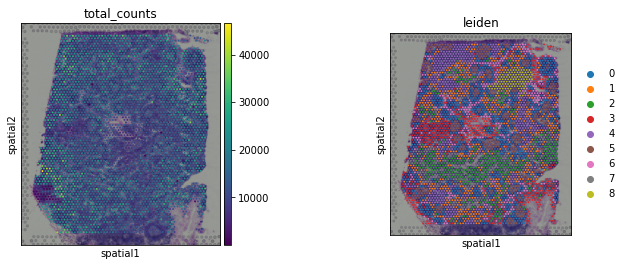

In [9]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "leiden"])

In [30]:
ripleyK(adata, cluster_key="leiden", support=100)

In [31]:
adata.uns["ripley_k_leiden"]

,ripley_k,distance,leiden
0,0.000000e+00,0.000000,2
1,0.000000e+00,62.073491,2
2,0.000000e+00,124.146982,2
3,4.530043e+05,186.220473,2
4,8.203245e+05,248.293965,2
...,...,...,...
73,6.669444e+07,4531.364854,5
74,6.888560e+07,4593.438346,5
75,7.047830e+07,4655.511837,5
76,7.271504e+07,4717.585328,5


/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'leiden'}, xlabel='spatial1', ylabel='spatial2'>

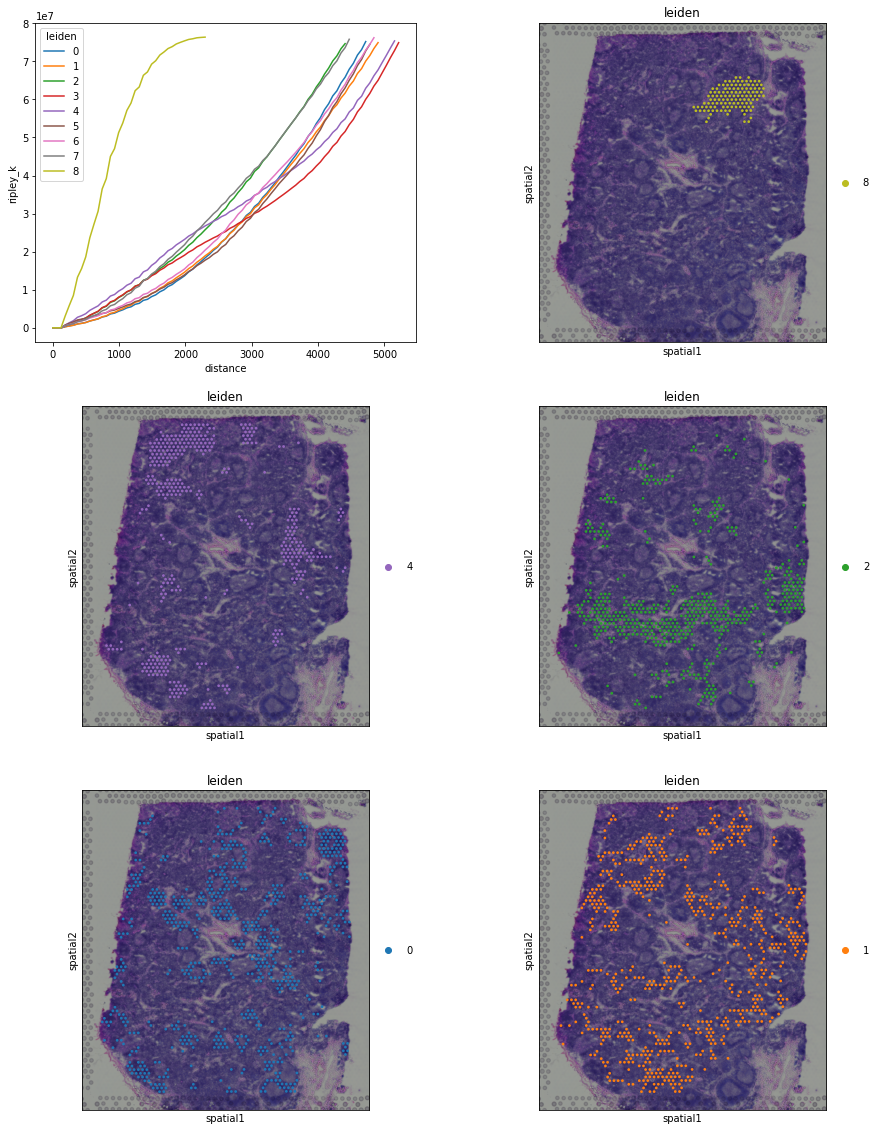

In [249]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
sns.lineplot(
    "distance",
    "ripley_k",
    hue="leiden",
    hue_order=[c for c in np.sort(adata.obs.leiden.unique())],
    data=rip_df,
    palette=[c for c in adata.uns["leiden_colors"]],
    ax=axs[0, 0],
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="8",
    ax=axs[0, 1],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="4",
    ax=axs[1, 0],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="2",
    ax=axs[1, 1],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="0",
    ax=axs[2, 0],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="1",
    ax=axs[2, 1],
    show=False,
)

Old implementation from points patterns

Problem is: since it's based on the full distance and not on the tissue are, clusters like the one below are missed. Need to find a way to pass distances of points based on the tissue area. 

In [178]:
rip_df = ripley_c(
    adata, dist_key="euclidean", cluster_key="leiden", r_name="k", support=100
)

/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'leiden'}, xlabel='spatial1', ylabel='spatial2'>

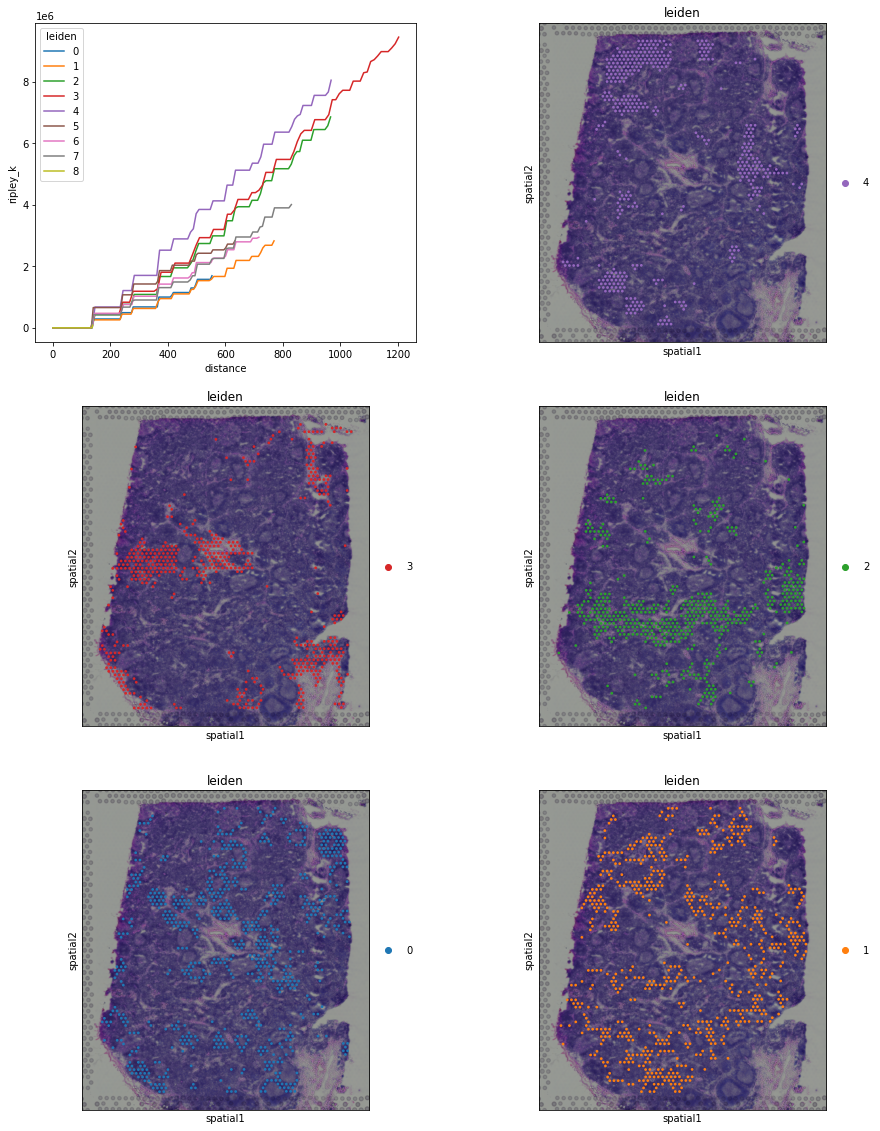

In [179]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
sns.lineplot(
    "distance",
    "ripley_k",
    hue="leiden",
    hue_order=[c for c in np.sort(adata.obs.leiden.unique())],
    data=rip_df,
    palette=[c for c in adata.uns["leiden_colors"]],
    ax=axs[0, 0],
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="4",
    ax=axs[0, 1],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="3",
    ax=axs[1, 0],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="2",
    ax=axs[1, 1],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="0",
    ax=axs[2, 0],
    show=False,
)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="1",
    ax=axs[2, 1],
    show=False,
)

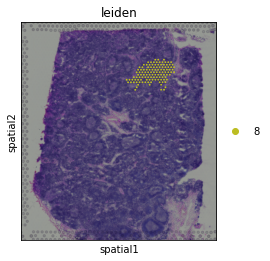

In [97]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="8",
)